In [1]:
import pandas as pd

import numpy as np

import itertools

from datetime import datetime

import time

import pytz
import sys
import pickle

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, max_error, r2_score

import seaborn as sns

import MetaTrader5 as mt5

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Reshape
from tensorflow.keras.callbacks import EarlyStopping

# LOAD DATA

In [2]:
sSymbol = "NAT.GAS"
gc_o_TIME_ZONE = pytz.timezone("Etc/UTC")
gc_dt_FROM = datetime(2021, 10, 1, tzinfo=gc_o_TIME_ZONE)
gc_dt_TO = datetime(2021, 11, 1, tzinfo=gc_o_TIME_ZONE)

In [3]:
aDatesToFetch = list(pd.date_range(start=gc_dt_FROM, end=gc_dt_TO)) #created since MT5 library fails due to time out.
aDatesSampled = aDatesToFetch[::200]
aDatesSampled.append(aDatesToFetch[-1])
aDatesSampled = list(set(aDatesSampled))
aDatesSampled.sort()

dfOhlc = pd.DataFrame()
for i in range(0, len(aDatesSampled) - 1):
    dtFrom = aDatesSampled[i]
    dtTo = aDatesSampled[i+1]

    if not mt5.initialize():
        print("initialize() failed, error code =", mt5.last_error())
        sys.exit()

    aSymbolInfo = mt5.symbol_info(sSymbol)
    if not aSymbolInfo:
        print("symbol_info() failed, error code =", mt5.last_error())
        sys.exit()

    dfOhlcSample = mt5.copy_rates_range(
        sSymbol,
        mt5.TIMEFRAME_M1,
        dtFrom, 
        dtTo
    )
    
    if len(dfOhlcSample) == 0:
        print("copy_rates_range() failed, error code =", mt5.last_error())
        sys.exit()

    mt5.shutdown()

    dfOhlcSample = pd.DataFrame(dfOhlcSample)

    dfOhlcSample['timestamp'] = pd.to_datetime(dfOhlcSample['time'], unit= "s")
    dfOhlcSample.set_index('timestamp', inplace=True)
    
    dfOhlc = dfOhlc.append(dfOhlcSample)

In [4]:
dfOhlc["weekday"] = dfOhlc.index.weekday
dfOhlc["hour"] = dfOhlc.index.hour
dfOhlc["minute"] = dfOhlc.index.minute

In [5]:
dfOhlc.drop(["time"], axis = 1 , inplace = True)

# DESCRIBE DATA

In [6]:
dfOhlc

,open,high,low,close,tick_volume,spread,real_volume,weekday,hour,minute
timestamp,,,,,,,,,,
2021-10-01 01:00:00,6.004,6.009,5.998,6.009,43,10,1290000,4,1,0
2021-10-01 01:01:00,6.009,6.047,6.008,6.045,73,10,2190000,4,1,1
2021-10-01 01:02:00,6.044,6.051,6.042,6.049,25,10,750000,4,1,2
2021-10-01 01:03:00,6.050,6.053,6.048,6.049,28,10,840000,4,1,3
2021-10-01 01:04:00,6.048,6.052,6.034,6.036,28,10,840000,4,1,4
...,...,...,...,...,...,...,...,...,...,...
2021-10-29 23:56:00,5.568,5.582,5.568,5.578,36,10,360000,4,23,56
2021-10-29 23:57:00,5.577,5.577,5.573,5.574,22,10,220000,4,23,57
2021-10-29 23:58:00,5.574,5.574,5.564,5.567,17,10,170000,4,23,58


# PREPROCESSING

In [7]:
sModelName = os.path.join(sSymbol , "__deep learning model__")

## Split Data

In [8]:
fTrainingRatio = 0.6
fValidationRatio = 0.2
fTestRatio = 0.2

ixTrain, ixTest = train_test_split(
    dfOhlc.index,
    test_size=1-fTrainingRatio,
    shuffle=False)

ixValidation, ixTest= train_test_split(
    ixTest,
    test_size=fTestRatio/(fTestRatio + fValidationRatio),
    shuffle=False)

## Scale Data

In [9]:
dfScaledOhlc = pd.DataFrame(index = dfOhlc.index, columns  = dfOhlc.columns)


for sColumn in dfOhlc.columns:
    oScaler = StandardScaler()
    
    dfTrain = pd.DataFrame(dfOhlc.loc[ixTrain, sColumn])
    dfValidation = pd.DataFrame(dfOhlc.loc[ixValidation, sColumn])
    dfTest = pd.DataFrame(dfOhlc.loc[ixTest, sColumn])
    
    oScaler.fit(dfTrain)
    
    dfScaledOhlc.loc[ixTrain, sColumn] = np.reshape(oScaler.transform(dfTrain), (-1))
    dfScaledOhlc.loc[ixValidation, sColumn] = np.reshape(oScaler.transform(dfValidation), (-1))
    dfScaledOhlc.loc[ixTest, sColumn] = np.reshape(oScaler.transform(dfTest), (-1))

    sScalerFilePath = os.path.join(sModelName , "__scalers__")
    sScalerFilePath = os.path.join(sScalerFilePath , sColumn + ".sav")
    os.makedirs(os.path.dirname(sScalerFilePath), exist_ok=True)
    pickle.dump(oScaler, open(sScalerFilePath, 'wb'))

## Feature Engineering

In [10]:
aInputFeatures = ['open', 'high', 'low', 'close', 'tick_volume', 'spread', 'real_volume','weekday', 'hour', 'minute']
iBackwardTimeWindow = 60
iNrInputFeatures = len(aInputFeatures)
aBackwardTimeSteps = range(-iBackwardTimeWindow, 0)

tplInputColumns = list(itertools.product(aBackwardTimeSteps, aInputFeatures))
miInputColums = pd.MultiIndex.from_tuples(tplInputColumns, names= ["time_step", "feature"])

dfInput = pd.DataFrame( columns = miInputColums)

for i in aBackwardTimeSteps:
    for sInputFeature in aInputFeatures:
        dfInput.loc[:, (i, sInputFeature)] = dfScaledOhlc[sInputFeature].shift(-i)

In [11]:
aOutputFeatures = ['close']
iForwardTimeWindow  =  60
iNrOutputFeatures = len(aOutputFeatures)
aForwardTimeSteps = range(0, iForwardTimeWindow)

tplOutputColumns = list(itertools.product(aForwardTimeSteps, aOutputFeatures))
ixOutputColums = pd.MultiIndex.from_tuples(tplOutputColumns, names= ["time_step", "feature"])

dfOutput = pd.DataFrame(columns = ixOutputColums)

for i in aForwardTimeSteps:
    for sOutputFeature in aOutputFeatures:
        dfOutput.loc[:, (i, sOutputFeature)] = dfScaledOhlc[sOutputFeature].shift(-i)

In [12]:
dfMerged = dfInput.join(dfOutput, how= "inner")
dfMerged.dropna(inplace=True)
dfInput = dfMerged[dfInput.columns]
dfOutput = dfMerged[dfOutput.columns]
ixTrain = ixTrain.join(dfMerged.index, how = "inner")
ixValidation = ixValidation.join(dfMerged.index, how = "inner")
ixTest = ixTest.join(dfMerged.index, how = "inner")

In [13]:
dfInputTrain = dfInput.loc[ixTrain]
aInputTrain = np.reshape(dfInputTrain.values, (dfInputTrain.shape[0], iBackwardTimeWindow, iNrInputFeatures))

dfInputValidation = dfInput.loc[ixValidation]
aInputValidation = np.reshape(dfInputValidation.values, (dfInputValidation.shape[0], iBackwardTimeWindow, iNrInputFeatures))

dfInputTest = dfInput.loc[ixTest]
aInputTest = np.reshape(dfInputTest.values, (dfInputTest.shape[0], iBackwardTimeWindow, iNrInputFeatures))

dfOutputTrain = dfOutput.loc[ixTrain]
aOutputTrain = np.reshape(dfOutputTrain.values, (dfOutputTrain.shape[0], iForwardTimeWindow, iNrOutputFeatures))

dfOutputValidation = dfOutput.loc[ixValidation]
aOutputValidation = np.reshape(dfOutputValidation.values, (dfOutputValidation.shape[0], iForwardTimeWindow, iNrOutputFeatures))

dfOutputTest = dfOutput.loc[ixTest]
aOutputTest = np.reshape(dfOutputTest.values, (dfOutputTest.shape[0], iForwardTimeWindow, iNrOutputFeatures))

In [14]:
aInputTrain = np.asarray(aInputTrain, np.float32)
aInputValidation = np.asarray(aInputValidation, np.float32)
aInputTest = np.asarray(aInputTest, np.float32)
aOutputTrain = np.asarray(aOutputTrain, np.float32)
aOutputValidation = np.asarray(aOutputValidation, np.float32)
aOutputTest = np.asarray(aOutputTest, np.float32)

## Train

### Set Hyperparameters

In [15]:
iBatchSize = 2048
iEpochSize = 10000

oOptimizer = tf.keras.optimizers.Adam(learning_rate=1e-05)

oEarlyStop = EarlyStopping(
    monitor = 'val_loss', 
    mode = 'min', 
    verbose = 0 , 
    patience = 20, 
    restore_best_weights = True)

### Build Model

In [16]:
aEncoderInputs = keras.Input(
    shape=(iBackwardTimeWindow, iNrInputFeatures), 
    name="aEncoderInputs")

aW1 = LSTM(200)(aEncoderInputs)
aW2 = Dense(iForwardTimeWindow * iNrOutputFeatures, 
                          kernel_initializer=tf.initializers.zeros(), 
                          name = "aOutputs")(aW1)
aOutputs = Reshape([iForwardTimeWindow, iNrOutputFeatures])(aW2)

oPredictiveModel = keras.Model(
    inputs=aEncoderInputs,
    outputs=aOutputs
)

### Compile Model

In [17]:
oFnLoss =  tf.keras.losses.MeanSquaredError()
oPredictiveModel.compile(optimizer=oOptimizer,
                         loss = oFnLoss
                        )

### Fit Model

In [18]:
oPredictiveModel.fit(
    aInputTrain, 
    aOutputTrain, 
    epochs=iEpochSize, 
    batch_size=iBatchSize, 
    verbose=1, 
    validation_data= (aInputValidation, aOutputValidation),
    validation_batch_size= iBatchSize,
    callbacks=[oEarlyStop]
)

Epoch 1/10000
9/9 [==============================] - 4s 229ms/step - loss: 1.0045 - val_loss: 1.6629
Epoch 2/10000
9/9 [==============================] - 2s 178ms/step - loss: 1.0020 - val_loss: 1.6585
Epoch 3/10000
9/9 [==============================] - 2s 178ms/step - loss: 0.9993 - val_loss: 1.6538
Epoch 4/10000
9/9 [==============================] - 2s 178ms/step - loss: 0.9965 - val_loss: 1.6488
Epoch 5/10000
9/9 [==============================] - 2s 178ms/step - loss: 0.9934 - val_loss: 1.6434
Epoch 6/10000
9/9 [==============================] - 2s 179ms/step - loss: 0.9901 - val_loss: 1.6376
Epoch 7/10000
9/9 [==============================] - 2s 178ms/step - loss: 0.9864 - val_loss: 1.6313
Epoch 8/10000
9/9 [==============================] - 2s 181ms/step - loss: 0.9825 - val_loss: 1.6245
Epoch 9/10000
9/9 [==============================] - 2s 181ms/step - loss: 0.9782 - val_loss: 1.6171
Epoch 10/10000
9/9 [==============================] - 2s 182ms/step - loss: 0.9734 - val_lo

9/9 [==============================] - 2s 183ms/step - loss: 0.2700 - val_loss: 0.3925
Epoch 82/10000
9/9 [==============================] - 2s 184ms/step - loss: 0.2660 - val_loss: 0.3857
Epoch 83/10000
9/9 [==============================] - 2s 183ms/step - loss: 0.2620 - val_loss: 0.3790
Epoch 84/10000
9/9 [==============================] - 2s 183ms/step - loss: 0.2581 - val_loss: 0.3724
Epoch 85/10000
9/9 [==============================] - 2s 184ms/step - loss: 0.2542 - val_loss: 0.3660
Epoch 86/10000
9/9 [==============================] - 2s 185ms/step - loss: 0.2505 - val_loss: 0.3597
Epoch 87/10000
9/9 [==============================] - 2s 183ms/step - loss: 0.2467 - val_loss: 0.3537
Epoch 88/10000
9/9 [==============================] - 2s 184ms/step - loss: 0.2431 - val_loss: 0.3478
Epoch 89/10000
9/9 [==============================] - 2s 184ms/step - loss: 0.2395 - val_loss: 0.3419
Epoch 90/10000
9/9 [==============================] - 2s 184ms/step - loss: 0.2359 - val_loss: 0.

Epoch 161/10000
9/9 [==============================] - 2s 189ms/step - loss: 0.0799 - val_loss: 0.1435
Epoch 162/10000
9/9 [==============================] - 2s 188ms/step - loss: 0.0788 - val_loss: 0.1408
Epoch 163/10000
9/9 [==============================] - 2s 184ms/step - loss: 0.0777 - val_loss: 0.1398
Epoch 164/10000
9/9 [==============================] - 2s 185ms/step - loss: 0.0766 - val_loss: 0.1382
Epoch 165/10000
9/9 [==============================] - 2s 188ms/step - loss: 0.0756 - val_loss: 0.1353
Epoch 166/10000
9/9 [==============================] - 2s 185ms/step - loss: 0.0746 - val_loss: 0.1345
Epoch 167/10000
9/9 [==============================] - 2s 184ms/step - loss: 0.0736 - val_loss: 0.1329
Epoch 168/10000
9/9 [==============================] - 2s 188ms/step - loss: 0.0726 - val_loss: 0.1309
Epoch 169/10000
9/9 [==============================] - 2s 184ms/step - loss: 0.0716 - val_loss: 0.1283
Epoch 170/10000
9/9 [==============================] - 2s 185ms/step - lo

9/9 [==============================] - 2s 185ms/step - loss: 0.0348 - val_loss: 0.0614
Epoch 241/10000
9/9 [==============================] - 2s 186ms/step - loss: 0.0346 - val_loss: 0.0603
Epoch 242/10000
9/9 [==============================] - 2s 186ms/step - loss: 0.0343 - val_loss: 0.0603
Epoch 243/10000
9/9 [==============================] - 2s 186ms/step - loss: 0.0341 - val_loss: 0.0600
Epoch 244/10000
9/9 [==============================] - 2s 186ms/step - loss: 0.0339 - val_loss: 0.0593
Epoch 245/10000
9/9 [==============================] - 2s 186ms/step - loss: 0.0336 - val_loss: 0.0596
Epoch 246/10000
9/9 [==============================] - 2s 185ms/step - loss: 0.0334 - val_loss: 0.0589
Epoch 247/10000
9/9 [==============================] - 2s 186ms/step - loss: 0.0332 - val_loss: 0.0586
Epoch 248/10000
9/9 [==============================] - 2s 186ms/step - loss: 0.0330 - val_loss: 0.0594
Epoch 249/10000
9/9 [==============================] - 2s 185ms/step - loss: 0.0328 - val

## Save Model

In [19]:
oPredictiveModel.save_weights(sModelName)

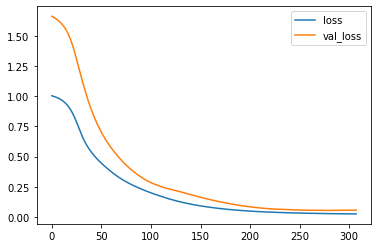

In [20]:
pd.DataFrame(oPredictiveModel.history.history).plot()

## Test Model

In [21]:
oPredictiveModel.load_weights(sModelName)

aPrediction = oPredictiveModel.predict(aInputTest)
aPrediction = aPrediction.reshape((-1, iForwardTimeWindow * iNrOutputFeatures))
dfPrediction = pd.DataFrame(aPrediction, index = ixTest, columns = ixOutputColums)

aActual = aOutputTest.reshape((-1, iForwardTimeWindow * iNrOutputFeatures))
dfActual =  pd.DataFrame(aActual, index = ixTest, columns = ixOutputColums)

for sOutputFeature in aOutputFeatures:
    sScalerFilePath = os.path.join(sModelName , "__scalers__")
    sScalerFilePath = os.path.join(sScalerFilePath , sColumn + ".sav")
    oScaler = pickle.load(open(sScalerFilePath, 'rb'))
    
    tplMaskFeature = (slice(None), slice(sOutputFeature))
    
    dfPrediction.loc[:,tplMaskFeature] = oScaler.inverse_transform(dfPrediction.loc[:, tplMaskFeature])
    dfActual.loc[:, tplMaskFeature] =  oScaler.inverse_transform(dfActual.loc[:, tplMaskFeature])

# RESULTS

In [26]:
iComparisionTimeStep = 1
iFrom = 50 * iForwardTimeWindow
iTo = iFrom + iForwardTimeWindow

In [27]:
y_pred = dfPrediction.iloc[:, iComparisionTimeStep]
y_true = dfActual.iloc[:, iComparisionTimeStep]
aMetrics = [
        ('mean absolute error', mean_absolute_error(y_true, y_pred)),
        ('mean squared error', mean_squared_error(y_true, y_pred)),
        ('max error', max_error(y_true, y_pred)),
        ('r2 score', r2_score(y_true, y_pred))
    ]

print('Metrics for regression:')
for metric_name, metric_value in aMetrics:
    print(f'{metric_name:>25s}: {metric_value: >20.3f}')

Metrics for regression:
      mean absolute error:                2.344
       mean squared error:                9.919
                max error:               12.657
                 r2 score:                0.935


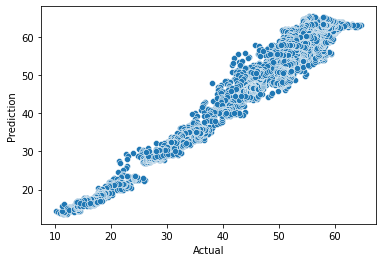

In [28]:
dfTestComparision = pd.DataFrame(dfPrediction.iloc[:,iComparisionTimeStep])
dfTestComparision = dfTestComparision.join(dfActual.iloc[:,iComparisionTimeStep], how = "inner", lsuffix="prediction")
dfTestComparision.columns = ["Prediction", "Actual"]

sns.scatterplot(data = dfTestComparision, x = "Actual", y ="Prediction")

-106.51502661886742


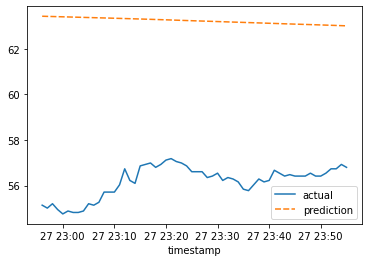

In [29]:
sFeatureName = "close"
dfStepComparision = dfActual.iloc[iFrom:iTo].loc[:, (slice(None), slice(sOutputFeature))].loc[:, 0]
dfStepComparision.columns = ["actual"]

dfStepComparision["prediction"] = dfPrediction.iloc[iFrom].loc[:, sFeatureName].values

print(r2_score(dfStepComparision["actual"], dfStepComparision["prediction"]))
sns.lineplot(data = dfStepComparision)

# REFERENCES

https://www.tensorflow.org/guide/keras/train_and_evaluate#passing_data_to_multi-input_multi-output_models

https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch/

https://www.tensorflow.org/guide/keras/customizing_what_happens_in_fit/

https://towardsdatascience.com/customize-loss-function-to-make-lstm-model-more-applicable-in-stock-price-prediction-b1c50e50b16c

https://keras.io/getting_started/faq/

https://machinelearningmastery.com/how-to-develop-lstm-models-for-multi-step-time-series-forecasting-of-household-power-consumption/

https://www.tensorflow.org/tutorials/structured_data/time_series

https://towardsdatascience.com/encoder-decoder-model-for-multistep-time-series-forecasting-using-pytorch-5d54c6af6e60